### Introduction
In this project we will create a model to analyze images of dogs and will output its guess of what breed it is.

We are using a dataset with 70 dog breeds with ~100 images per breed.

To create the model we used transfer learning with a variety of pretained models like: densenet, imagenet, ... then added new layers and fine tuning to make it work better for identifying dog breeds.

### Data Pre-Processing


In [1]:
# Import all the necessary modules

import os
import shutil
import tensorflow as tf
import keras
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

from tensorflow.keras.applications.densenet import decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Get the pre-trained DenseNet model

model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

2024-04-21 22:20:33.082339: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 22:20:36.260201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-04-21 22:20:36.262025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-04-21 22:20:36.263661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

In [3]:
# Funtions to show the images, load and process them to the correct input shape and make a prediction

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

def densenet_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(224, 224, 3)


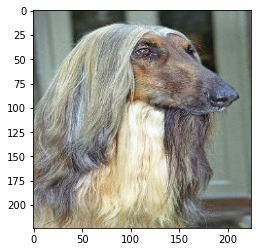

In [4]:
# Check that show_image works
show_image("test/Afghan/04.jpg")

In [5]:
processed_image = load_and_process_image("test/Afghan/04.jpg")

Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


2024-04-21 22:20:40.740745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


Predicted: [[('n02085936', 'Maltese_dog', 0.8320847), ('n02098413', 'Lhasa', 0.08446608), ('n02098286', 'West_Highland_white_terrier', 0.01873539)]]


2024-04-21 22:20:42.847055: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


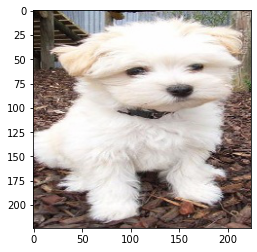

In [6]:
densenet_prediction("test/Maltese/04.jpg")

### Model setup

In [7]:
from tensorflow.keras.models import Model

num_classes = 70

# Define the base model (DenseNet121) without the top classification layer
base_model = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Freeze the pre-trained layers
base_model.trainable = False

# Add a custom classification head
global_average_layer = GlobalAveragePooling2D()(base_model.output)
output_layer = Dense(num_classes, activation='softmax')(global_average_layer)

# Combine the base model with the custom classification head
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
#model.summary()


In [8]:
# Get current working directory
current_dir = os.getcwd()

# Define the directories for training, validation, and testing data
train_dir = os.path.join(current_dir, 'train')
valid_dir = os.path.join(current_dir, 'valid')
test_dir = os.path.join(current_dir, 'test')

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    # Augmentation techniques
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ImageDataGenerator for validation and testing data
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6390 images belonging to 70 classes.
Found 706 images belonging to 70 classes.
Found 702 images belonging to 70 classes.


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [12]:
import albumentations as A  # Make sure to install albumentations package
# Display augmented images
# Load the image
image_path = "test/Bluetick/04.jpg"  # Replace with the path to your image
image = image_utils.load_img(image_path, target_size=(224, 224))
image = image_utils.img_to_array(image)

# Define augmentation techniques
augments = [
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.CoarseDropout(p=1),
    A.CLAHE(p=1)
]

# Plot the original image and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.title('Original')
plt.imshow(image.astype(np.uint8))

# Apply each augmentation technique and plot the augmented image
for i, augment in enumerate(augments):
    augmented_img = augment(image=image.astype(np.uint8))['image']  # Ensure the image is uint8
    plt.subplot(3, 3, i + 2)
    plt.title(f'Augmented {i + 1}')
    plt.imshow(augmented_img.astype(np.uint8))
plt.show()


ModuleNotFoundError: No module named 'albumentations'

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=validation_generator
)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
200/200 [==============================] - 63s 298ms/step - loss: 1.8209 - accuracy: 0.6003 - val_loss: 0.6662 - val_accuracy: 0.8867
Epoch 2/10
200/200 [==============================] - 59s 293ms/step - loss: 0.5201 - accuracy: 0.8817 - val_loss: 0.5028 - val_accuracy: 0.9164
Epoch 3/10
200/200 [==============================] - 58s 289ms/step - loss: 0.3699 - accuracy: 0.9088 - val_loss: 0.5048 - val_accuracy: 0.9150
Epoch 4/10
200/200 [==============================] - 58s 291ms/step - loss: 0.2999 - accuracy: 0.9208 - val_loss: 0.4803 - val_accuracy: 0.9278
Epoch 5/10
200/200 [==============================] - 58s 291ms/step - loss: 0.2645 - accuracy: 0.9257 - val_loss: 0.4878 - val_accuracy: 0.9164
Epoch 6/10
200/200 [==============================] - 58s 290ms/step - loss: 0.2332 - accuracy: 0.9385 - val_loss: 0.5117 - val_accuracy: 0.9235
Epoch 7/10
200/200 [==============================] - 58s 290ms/step - loss: 0.2073 - accuracy: 0.9387 - val_loss: 0.4839 - val_ac

### Hyperparameter Tuning

In [ ]:

# Compile the new model
model.trainable = True
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(train_generator, batch_size=32, epochs=10, verbose=1, validation_data=validation_generator)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
# Compile the new model
model.trainable = True
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(train_generator, batch_size=32, epochs=10, verbose=1, validation_data=validation_generator)
​
test_loss, test_accuracy = model.evaluate(test_generator)
​
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

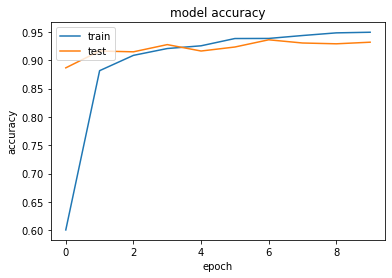

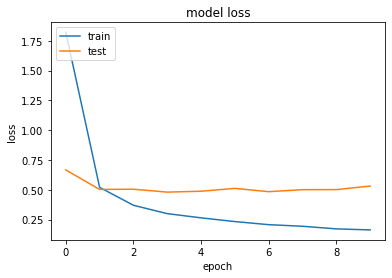

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Borzoi, Probability: 0.9999065399169922
Predicted class: Greyhound, Probability: 5.497474558069371e-05
Predicted class: Afghan, Probability: 1.296355821978068e-05


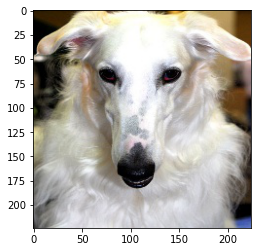

In [15]:
dog_species = [name for name in os.listdir('./test') if os.path.isdir(os.path.join('./test', name))]
dog_species.sort()
# print(dog_species)

def display_top_predictions(predictions, top=3):
    # Get the top predicted classes and corresponding probabilities
    top_indices = np.argsort(predictions)[0][-top:][::-1]
    top_probabilities = predictions[0][top_indices]
    
    # Print the top predictions
    for i in range(top):
        print(f"Predicted class: {dog_species[top_indices[i]]}, Probability: {top_probabilities[i]}")

        
def model_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    #Display top predictions
    display_top_predictions(predictions)
    
model_prediction("valid/Borzoi/01.jpg")

Found 712 images belonging to 70 classes.


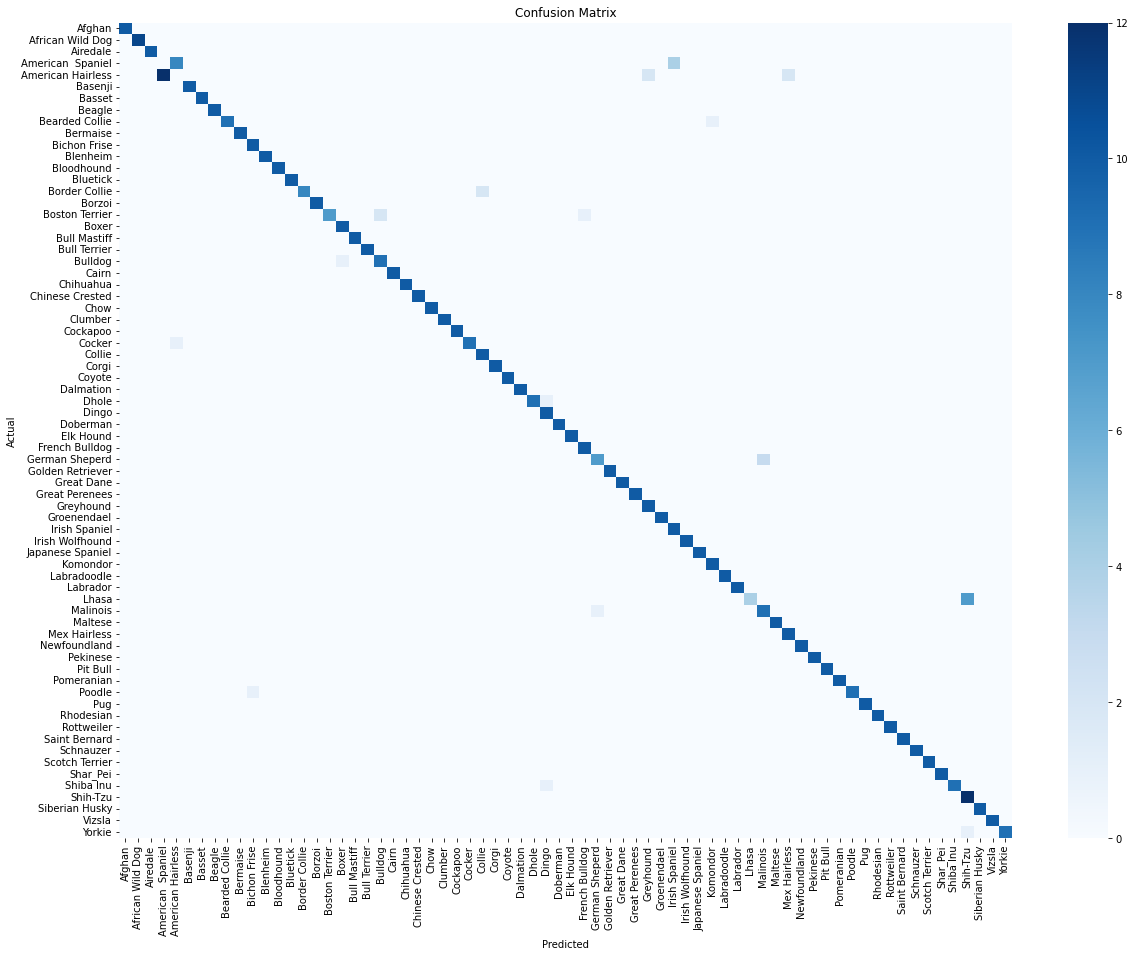

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Disable shuffling in the test generator
test_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffling
)

# Predict classes for the test set
y_true = test_generator.classes

# Disable Dropout layers during inference
model.evaluate(test_generator, verbose=0)

# Predict classes for the test set again
y_pred = model.predict(test_generator).argmax(axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: American Spaniel, Probability: 0.5522700548171997
Predicted class: Cocker, Probability: 0.43176811933517456
Predicted class: Irish Spaniel, Probability: 0.008515511639416218


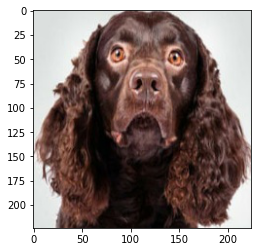

In [43]:
model_prediction("valid/American  Spaniel/04.jpg")

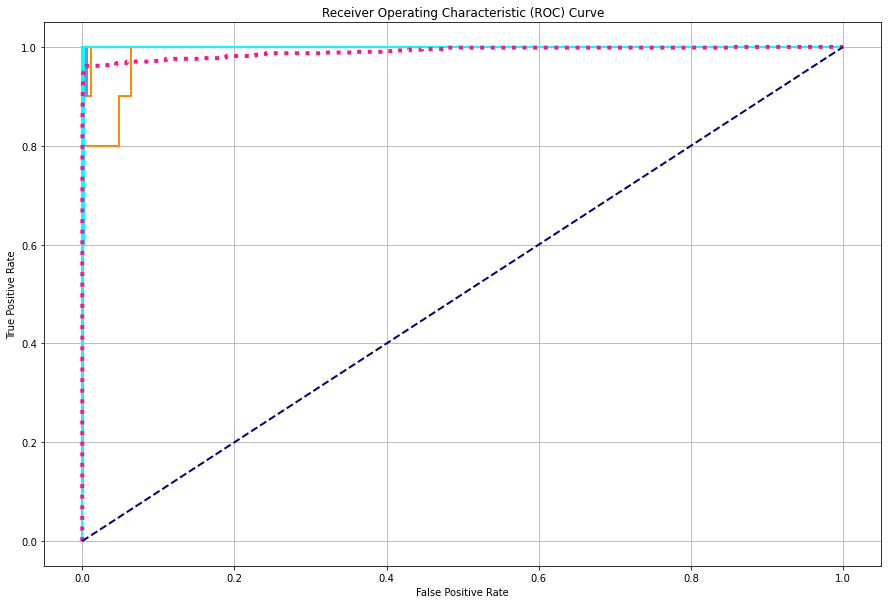

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Predict probabilities for each class for the test set
y_score = model.predict(test_generator)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_true))):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(np.unique(y_true))), colors):
    
    # Shows that the model gets the American Spaniel and American Hairless mixed up
    if (i == 3 or i == 4):
        continue
        
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro,
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Results

- The final accuracy after fine tuning was determined to be 0.984 with a loss of 0.00248058
- These are very good values and means that our model achieved its goal of being able to accurately predict dog breeds based on inputted images
- The confusion matric and ROC Curve also reflect this conclusion.

### Discussion

- It was difficult to generate the ROC curve and confusion matrix since we had to edit the data to be in the correct data structure.
- After they were generated, we found that the model gets confused between the American Hairless and American Spaniel
- The model also identifies the Shih Tzu as a Lhasa, which are very similar in appearance
- These weaknesses could be further improved on in future implementations of this algorithm. It could also be expanded to take in other dog breeds, and even whole other species all together.